In [4]:
import numpy as np
from scipy.linalg import expm, sinm, cosm
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
from scipy.special import iv

In [5]:
def theoretical_acf(rho, upper_bound):
    acf = []
    acf_denom = iv(0, 2.0 * rho)
    
#     for j in range(0,20):
#         acf_denom = acf_denom+ ( (rho)**(2j) / (math.factorial(j)*math.factorial(j) ) )


    for h in range(0,upper_bound):
        acf_num = iv(h, 2.0*rho)
        
#         for j in range(0,20):
#             acf_num = acf_num + ( (rho)**(2j+h) / (math.factorial(j)*math.factorial(j+h) ) )
        
        acf.append( (acf_num/acf_denom).real)
        
    return acf

In [6]:
max_h = 10
acf_df = pd.DataFrame(columns = range(0,max_h))

acf_df.loc[0] = np.zeros(max_h)
acf_df.loc[0,0]=1

rho_grid = np.append(np.linspace(.1,1,10),np.array([1.5,2.0]))
for rho in rho_grid:
    acf_df.loc[rho] = np.array(theoretical_acf(rho, max_h))
    
acf_df = acf_df.reset_index()

Text(0.5, 1.0, 'ACF for various values of rho')

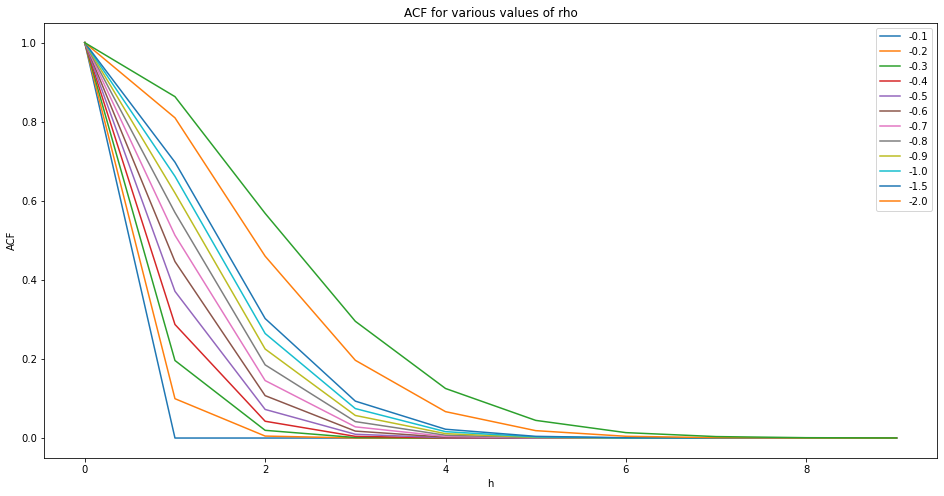

In [7]:
fig, ax = plt.subplots(figsize = (16,8))

pd.pivot_table(acf_df, columns = 'index').plot(ax = ax)
ax.legend( np.round(-1*rho_grid,1)  )

ax.set_xlabel('h')
ax.set_ylabel('ACF')
ax.set_title('ACF for various values of rho')

Text(0.5, 1.0, 'ACF for various values of rho')

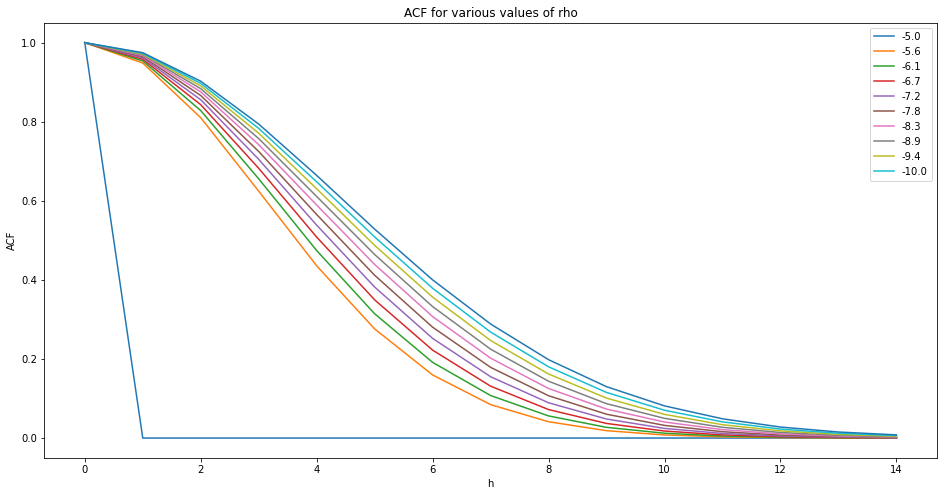

In [8]:
max_h = 15
acf_df = pd.DataFrame(columns = range(0,max_h))

acf_df.loc[0] = np.zeros(max_h)
acf_df.loc[0,0]=1

rho_grid = np.linspace(5,10,10)
for rho in rho_grid:
    acf_df.loc[rho] = np.array(theoretical_acf(rho, max_h))
    
acf_df = acf_df.reset_index()

fig, ax = plt.subplots(figsize = (16,8))

pd.pivot_table(acf_df, columns = 'index').plot(ax = ax)
ax.legend( np.round(-1*rho_grid,1)  )

ax.set_xlabel('h')
ax.set_ylabel('ACF')
ax.set_title('ACF for various values of rho')

In [13]:
sample_size = 50
L_approx = np.zeros([sample_size, sample_size])

for row in range(0,len(L_approx)-1):
    L_approx[row][row+1] =1
    
L_approx[sample_size -1 ] = np.ones(sample_size)/sample_size

phi = -1
wold_operator = np.linalg.inv(expm(phi*L_approx))

Text(0.5, 0, 'Time')

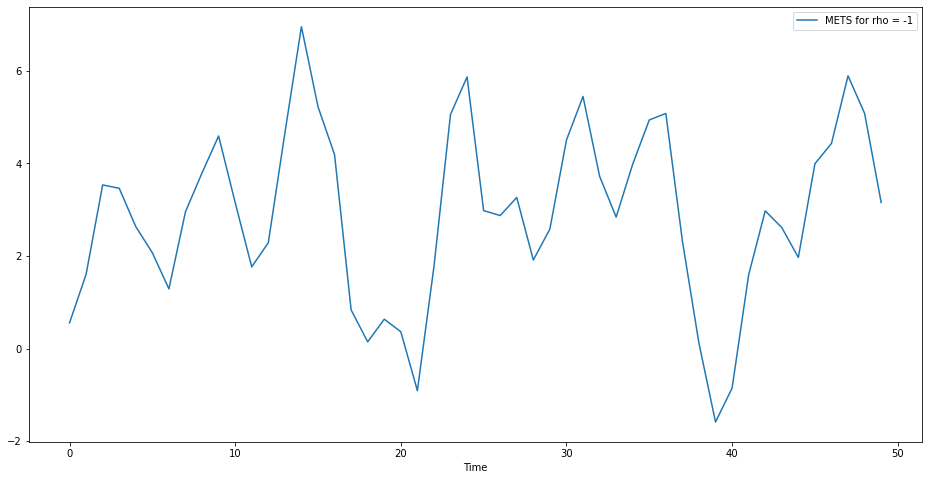

In [14]:
ep = np.random.normal(1,1,sample_size)
ts = np.dot(wold_operator,ep)

fig, ax = plt.subplots(figsize = (16,8))
pd.DataFrame(ts).plot(ax = ax)
ax.legend(['METS for rho = -1'])
ax.set_xlabel('Time')

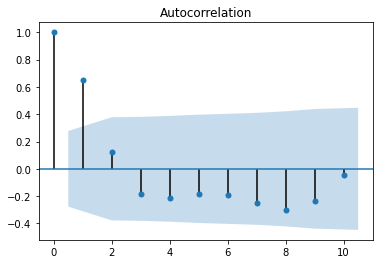

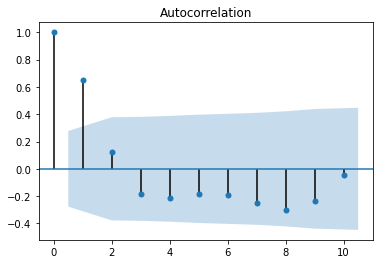

In [15]:
sm.graphics.tsa.plot_acf(ts, lags=10)

In [90]:
def msts_filter(alpha, rho, ts,y0):
    state_space = [y0]
    fitted = [y0]
    
    sample_length = len(ts)
    for time in range(1,sample_length):
        state_space = state_space[:20]
        state_space  = np.append(ts[time-1],state_space)
        state_space = rho*state_space
        
        for entry in range(0, len(state_space)):
            state_space[entry] = state_space[entry]/math.factorial(entry+1)
            
        fitted = np.append(fitted, alpha + np.sum(state_space) )
        
    return fitted

def ols_msts(ts,grid_size):
    ts_mean = np.mean(ts)
#     y0 = np.mean(ts)
    y0 = ts[0]
    
    min_alpha = 0.0
    min_rho = 0.0
    min_obj = np.square(ts - msts_filter(0.0, 0.0,ts,y0)).mean()
    
    for alpha in np.linspace(-ts_mean, ts_mean, grid_size):
        for rho in np.linspace(-2,2,grid_size):
            obj = np.square(ts - msts_filter(alpha, rho,ts,y0)).mean()
            
            if obj < min_obj:
                min_alpha = alpha
                min_rho = rho
                min_obj = obj
                
    return [min_alpha, min_rho]

In [37]:
def mets_filter_lags(ts,phi):

    sample_size = len(ts)
    L_approx = np.zeros([sample_size, sample_size])

    for row in range(0,len(L_approx)-1):
        L_approx[row][row+1] =1

    L_approx[sample_size -1 ] = np.ones(sample_size)/sample_size

    phi = phi
    wold_operator = np.linalg.inv(expm(phi*L_approx))
    return np.dot(wold_operator,ts)


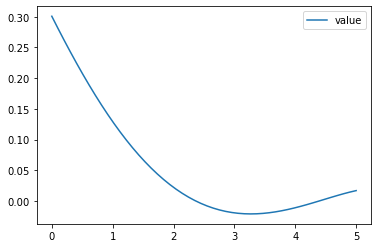

In [44]:
exp_cf = pd.DataFrame(columns = ['value'])

xbar = np.mean(ts)
sigsq = np.dot(ts,ts)

for rho in np.linspace(0,5,50):
    exp_cf.loc[rho] = np.dot(ts - xbar ,mets_filter_lags(ts,rho) - xbar)/sigsq
    
exp_cf.plot()

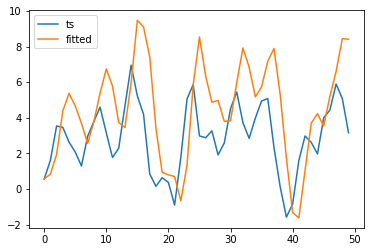

In [45]:
pd.DataFrame({'ts':ts, 'fitted':msts_filter(0,1,ts, ts[0])}).plot()

In [46]:
ols_coefs = ols_msts(ts,20)
ols_coefs

[1.0636885823484419, 0.5263157894736841]

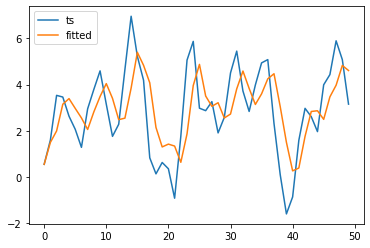

In [47]:
pd.DataFrame({'ts':ts, 'fitted':msts_filter(ols_coefs[0],ols_coefs[1],ts, ts[0] )}).plot()

In [48]:
income_ts = pd.read_excel('C:/Users/michelj8/Documents/GitHub/expo_smooth_lasso\METS/fred_household_income.xls', sheet_name = 'data')
income_ts.head()

,observation_date,MEHOINUSA672N
0,1984-01-01,52679
1,1985-01-01,53664
2,1986-01-01,55597
3,1987-01-01,56261
4,1988-01-01,56725


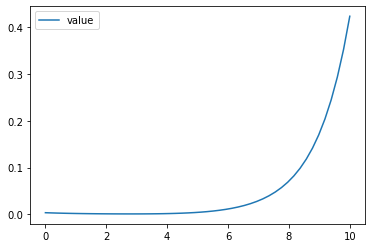

In [53]:
exp_cf = pd.DataFrame(columns = ['value'])
ts = income_ts['MEHOINUSA672N']

xbar = np.mean(ts)
sigsq = np.dot(ts,ts)

for rho in np.linspace(0,10,50):
    exp_cf.loc[rho] = np.dot(ts - xbar ,mets_filter_lags(ts,rho) - xbar)/sigsq
    
exp_cf.plot()

In [54]:
income_ts['Y'] = np.log(income_ts['MEHOINUSA672N']).dropna()
income_ts['Y2'] = np.log(income_ts['MEHOINUSA672N']).diff().dropna()

In [55]:
income_ols_coefs = ols_msts( income_ts['MEHOINUSA672N'] ,25)

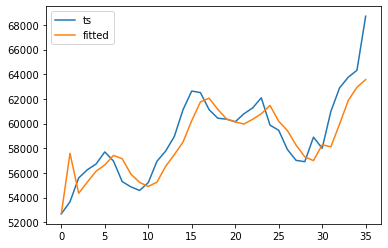

In [61]:
pd.DataFrame({'ts':income_ts['MEHOINUSA672N'], 'fitted':msts_filter(income_ols_coefs[0],income_ols_coefs[1],income_ts['MEHOINUSA672N'], income_ts['MEHOINUSA672N'][0])}).plot()
# pd.DataFrame({'ts':income_ts['Y'], 'fitted':msts_filter(income_ols_coefs[0],income_ols_coefs[1],income_ts['Y'], income_ts['Y'][0])}).plot()

In [62]:
income_ols_coefs

[4917.8263888888905, 0.6666666666666665]

In [63]:
from statsmodels.tsa.arima.model import ARIMA

arma_model = ARIMA(income_ts['MEHOINUSA672N'], order=(1, 0, 0)).fit()
print(arma_model.params)

const     5.901392e+04
ar.L1     9.734766e-01
sigma2    2.050352e+06
dtype: float64


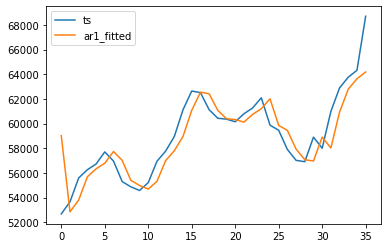

In [64]:
pd.DataFrame({'ts':income_ts['MEHOINUSA672N'], 'ar1_fitted':arma_model.predict() }).plot()

In [65]:
error = np.square(income_ts['MEHOINUSA672N'] - msts_filter(income_ols_coefs[0],income_ols_coefs[1],income_ts['MEHOINUSA672N'], income_ts['MEHOINUSA672N'][0])).mean()
ar_error = np.square(income_ts['MEHOINUSA672N'] -arma_model.predict() ).mean()

error/ar_error

0.9705724719595379

In [68]:
l1_error = np.abs(income_ts['MEHOINUSA672N'] - msts_filter(income_ols_coefs[0],income_ols_coefs[1],income_ts['MEHOINUSA672N'], income_ts['MEHOINUSA672N'][0])).mean()
l1_ar_error = np.abs(income_ts['MEHOINUSA672N'] -arma_model.predict() ).mean()

l1_error/l1_ar_error

1.0774964477094464

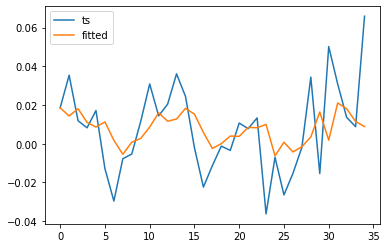

In [69]:
ts = np.array(income_ts['Y2'].dropna())

income_logdif_ols_coefs = ols_msts( ts ,25)
pd.DataFrame({'ts':ts, 'fitted':msts_filter(income_logdif_ols_coefs[0],income_logdif_ols_coefs[1],ts, ts[0])}).plot()

In [74]:
income_logdif_ols_coefs

[0.005058589947396303, 0.33333333333333304]

array([0.00861852, 0.34969143, 0.00045102])

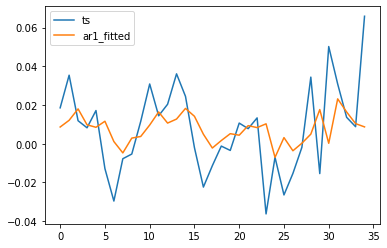

In [77]:
logdif_arma_model = ARIMA(ts , order=(1, 0, 0)).fit()
pd.DataFrame({'ts':ts, 'ar1_fitted':logdif_arma_model.predict() }).plot()
logdif_arma_model.params

In [71]:
ld_error = (ts-msts_filter(income_logdif_ols_coefs[0],income_logdif_ols_coefs[1],ts, ts[0]))
ar_ld_error  = (ts - logdif_arma_model.predict())

# ld_error/ar_ld_error

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002F38A1A8760>],
      dtype=object)

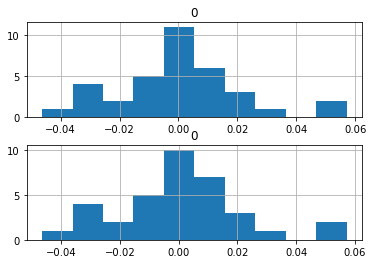

In [72]:
fig, [ax1,ax2] = plt.subplots(2,1)

pd.DataFrame(ld_error).hist(ax = ax1)
pd.DataFrame(ar_ld_error).hist(ax= ax2)


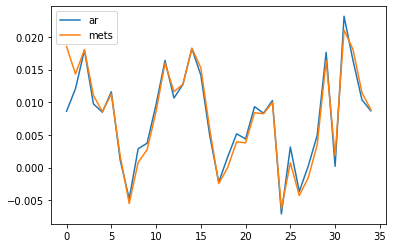

In [78]:
pd.DataFrame({'ar':logdif_arma_model.predict(), 'mets':msts_filter(income_logdif_ols_coefs[0],income_logdif_ols_coefs[1],ts, ts[0])}).plot()

In [80]:
ts- msts_filter(income_logdif_ols_coefs[0],income_logdif_ols_coefs[1],ts, ts[0])

array([ 0.        ,  0.02106552, -0.0061826 , -0.00282808,  0.00856279,
       -0.02415188, -0.03138517, -0.00228333, -0.00613657,  0.00879852,
        0.02226572, -0.00154874,  0.0087579 ,  0.02334784,  0.00618253,
       -0.01733877, -0.02826327, -0.00891623, -0.0012598 , -0.00742896,
        0.00685784, -0.00064395,  0.00509897, -0.04625769, -0.0007482 ,
       -0.02722676, -0.01109596, -0.00035517,  0.03091776, -0.03182007,
        0.04838677,  0.00981372, -0.00445849, -0.00267832,  0.05701665])

In [82]:
msts_filter(income_logdif_ols_coefs[0],income_logdif_ols_coefs[1],ts, ts[0])

array([ 1.85254915e-02,  1.43213357e-02,  1.80549354e-02,  1.10415312e-02,
        8.56600125e-03,  1.12626531e-02,  1.73964419e-03, -5.48609949e-03,
        7.82761297e-04,  2.75030242e-03,  8.58551016e-03,  1.59670750e-02,
        1.16140746e-02,  1.27459828e-02,  1.82674641e-02,  1.52772968e-02,
        5.84203921e-03, -2.45266757e-03,  1.80224055e-05,  3.94377312e-03,
        3.79182147e-03,  8.41053137e-03,  8.22828754e-03,  9.96520712e-03,
       -6.27407535e-03,  7.43049325e-04, -4.27088289e-03, -1.55823729e-03,
        3.48502915e-03,  1.63713199e-02,  1.81370555e-03,  2.10399154e-02,
        1.80858451e-02,  1.14694131e-02,  8.84340702e-03])

In [86]:
income_logdif_ols_coefs

[0.005058589947396303, 0.33333333333333304]

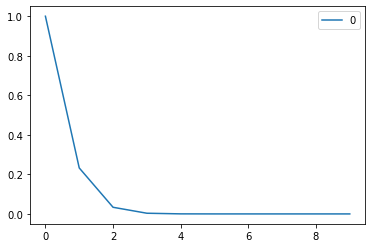

In [89]:
pd.DataFrame(theoretical_acf(income_logdif_ols_coefs[1],10)).plot()

In [190]:
fred_ts = pd.read_excel('C:/Users/michelj8/Documents/GitHub/expo_smooth_lasso/METS/inflation.xlsx', sheet_name = 'data')
ts = fred_ts['FPCPITOTLZGUSA']

fred_ts.head()

,observation_date,FPCPITOTLZGUSA
0,1960-01-01,1.457976
1,1961-01-01,1.070724
2,1962-01-01,1.198773
3,1963-01-01,1.239669
4,1964-01-01,1.278912


In [191]:
ols_coefs = ols_msts( ts ,25)

In [193]:
ols_coefs

[0.3100703951022168, 0.6666666666666665]

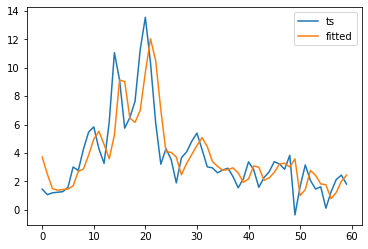

In [194]:
pd.DataFrame({'ts':ts, 'fitted':msts_filter(ols_coefs[0],ols_coefs[1],ts,np.mean(ts) )}).plot()

In [195]:
arma_model = ARIMA(ts, order=(1, 0, 0)).fit()
print(arma_model.params)

const     3.454438
ar.L1     0.814581
sigma2    2.487868
dtype: float64


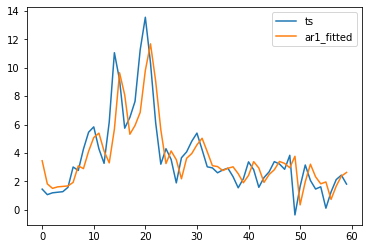

In [197]:
pd.DataFrame({'ts':ts, 'ar1_fitted':arma_model.predict() }).plot()

In [199]:
error = np.abs(ts - msts_filter(ols_coefs[0],ols_coefs[1],ts,np.mean(ts) ) ).mean()
ar_error = np.abs(ts -arma_model.predict() ).mean()

error/ar_error

1.0572406750657168

In [205]:
from scipy.special import iv
iv(1,.6667)/iv(0,.6667)

0.316103439616426

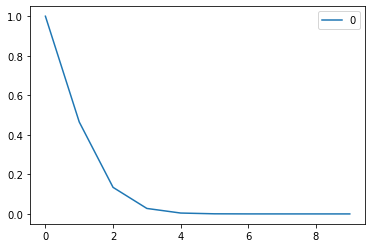

In [209]:
pd.DataFrame((theoretical_acf(.6667,10))).plot()